In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from numpy import roll 
# next point np.roll(u, -1)
# previous point np.roll(u, 1)

### parameters ###
L, T = 1, 1
dx = 0.01
c, CFL = 1, 0.2

N_x = int(L/dx)
x = np.linspace(-L/2, L/2, N_x)

dt = CFL * dx
N_t = int(T/dt)

### initial and periodic boundary condition ###
def initial_condition(x):
    width, height, center = 0.2, 1, 0.0
    u_initial = np.where(np.abs(x-center) <= width/2, height, 0)
    return u_initial

### The discretized flux ###
def F(u, dx, c=c):
    up1, um1 = roll(u, -1), roll(u, 1)
    du_dx = (up1 - um1) / (2 * dx)
    return -c * du_dx

### Create the animation and plot ###
def plot(x,utx, title, params, dt, save_anim=False, filename="burgers_solution"):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, utx[0])

    line, = ax.plot(x, utx[0])
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_title(title)
    ax.set_ylim(-0.5, 1.5)  # Set y-axis limits based on expected solution range

    def update(frame):
        line.set_ydata(utx[frame])
        ax.set_title(f"{title} (t = {frame * dt:.4f})\n{params}")
        return line,

    anim = animation.FuncAnimation(fig, update, frames=len(utx), interval=100, blit=True)

    # Save the animation (optional)
    if save_anim:
        anim.save(f'{filename}.gif', writer='pillow')

    ax.plot(x, utx[-1])
    plt.show()


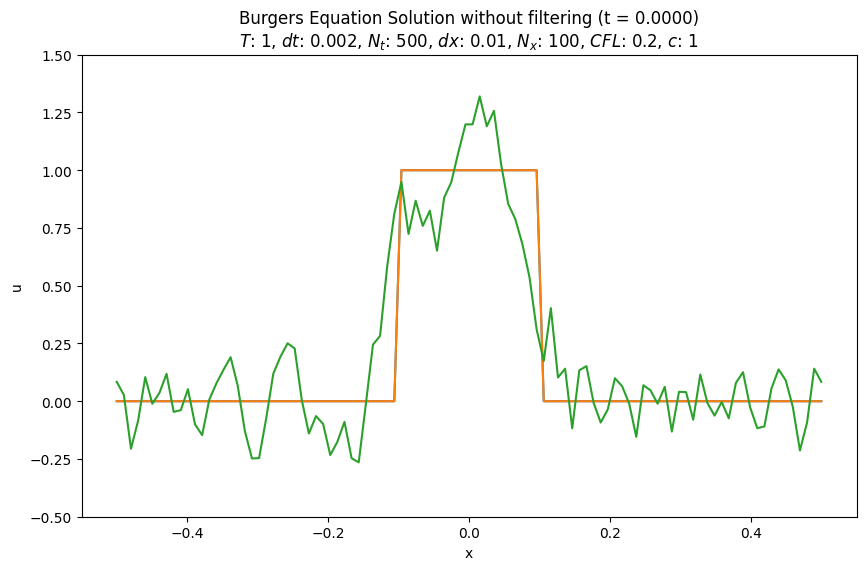

In [2]:
### RK4 ###
def RK4(u, dx, dt):
    k1 = F(u, dx)
    k2 = F(u + 0.5 * dt * k1, dx)
    k3 = F(u + 0.5 * dt * k2, dx)
    k4 = F(u + dt * k3, dx)
    return u + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

### Burgers equation: du/dt = -c * du/dx = F(u, dx, c) ###
def solve_Burgers(u_initial, dx, dt, N_t):
    utx = [u_initial.copy()]
    for _ in range(N_t):
        u = RK4(utx[-1], dx, dt)
        utx.append(u.copy())
    return utx

### main ###
u_initial = initial_condition(x)
utx = solve_Burgers(u_initial, dx, dt, N_t)

title = "Burgers Equation Solution without filtering"
params = f"$T$: {T}, $dt$: {dt}, $N_t$: {N_t}, $dx$: {dx}, $N_x$: {N_x}, $CFL$: {CFL}, $c$: {c}"
plot(x, utx, title, params, dt, save_anim=False, filename="burgers_solution_without_filtering")


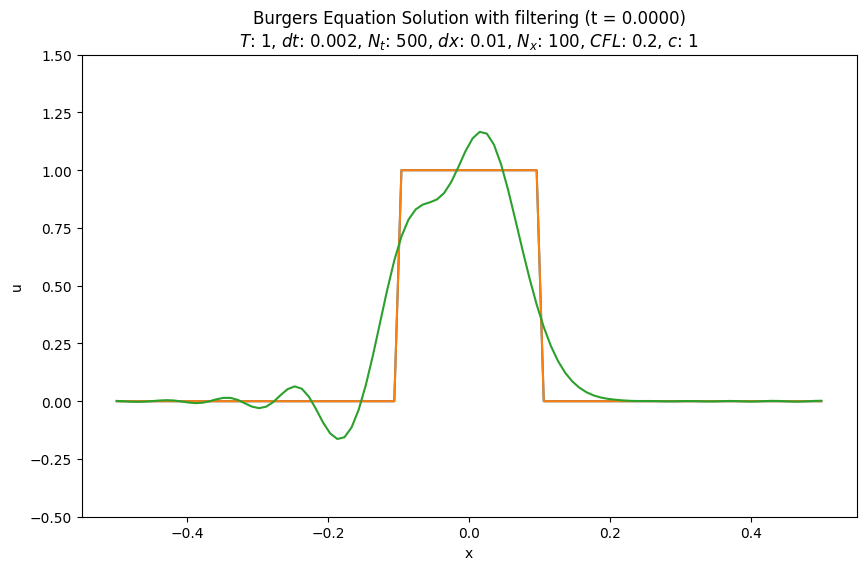

In [3]:
def filter_flux(u, dx, dt):
    up1, up2, up3, up4 = roll(u, -1), roll(u, -2), roll(u, -3), roll(u, -4)
    um1, um2, um3, um4 = roll(u, 1), roll(u, 2), roll(u, 3), roll(u, 4)

    max_g, min_g = max(u), min(u)
    max_l = np.max([up2,up1,u,um1,um2],axis=0)
    min_l = np.min([up2,up1,u,um1,um2],axis=0)

    Ru = ( 4*(up1+um1) - (up2+um2) )/6.0

    ce,cs = 2000,0.1
    D = cs*(max_g-min_g) + (1-cs)*(max_l-min_l)+1e-6
    e = abs(Ru - u)/D 
    ep1 = roll(e,-1)
    e = np.max([e,ep1],axis=0)
    w = 1-np.exp(-ce*e**2)

    f8 = (35*(up1-u)-21*(up2-um1)+7*(up3-um2)-(up4-um3))/(4**4) # eq. 2
    f2 = (up1-u)/4
    f = w*f2 + (1-w)*f8
    fm1 = roll(f,+1)
    Fu = u + dt/dx*(f - fm1) # eq. 1
    return Fu

def solve_Burgers_with_filter(u_initial, dx, dt, N_t):
    utx = [u_initial.copy()]
    for _ in range(N_t):
        u = RK4(utx[-1], dx, dt)
        u = filter_flux(u, dx, dt)
        utx.append(u.copy())
    return utx

### main ###
u_initial = initial_condition(x)
utx = solve_Burgers_with_filter(u_initial, dx, dt, N_t)

title = "Burgers Equation Solution with filtering"
params = f"$T$: {T}, $dt$: {dt}, $N_t$: {N_t}, $dx$: {dx}, $N_x$: {N_x}, $CFL$: {CFL}, $c$: {c}"
plot(x, utx, title, params, dt, save_anim=False, filename="burgers_solution_with_filtering")


In [4]:
import torch.nn as nn
import torch

class BurgersMLPFilter(nn.Module):
    def __init__(self, input_size, hidden_layers=[50, 30, 20], dropout_rate=0.1):

        super(BurgersMLPFilter, self).__init__()
        
        # Create layers dynamically
        layers = []
        prev_size = input_size
        
        for layer_size in hidden_layers:
            layers.extend([
                nn.Linear(prev_size, layer_size),
                nn.BatchNorm1d(layer_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = layer_size
        
        # Final layer to output weight
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())  # Constrain weight between 0 and 1
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

def d_alembert_solution(u_initial_array, x_initial_array, dt, c): # linear_advection_step_periodic
    num_points = len(x_initial_array)
    dx = x_initial_array[1] - x_initial_array[0] 
    shift = int(c * dt / dx)
    shifted_indices = (np.arange(num_points) - shift) % num_points    
    u_next = u_initial_array[shifted_indices]
    return u_next

def prepare_input_features(u):
    up1, up2 = np.roll(u, -1), np.roll(u, -2)
    um1, um2 = np.roll(u, 1), np.roll(u, 2)
    features = np.column_stack([um2, um1, u, up1, up2])    
    return torch.tensor(features, dtype=torch.float32)

model = BurgersMLPFilter(input_size=5)

Model loaded from burgers_mlp_filter.pth
epoch:  10 loss: 0.00064
Model saved to burgers_mlp_filter.pth
epoch:  20 loss: 0.00069
Model saved to burgers_mlp_filter.pth
epoch:  30 loss: 0.00066
Model saved to burgers_mlp_filter.pth
epoch:  40 loss: 0.00070
Model saved to burgers_mlp_filter.pth
epoch:  50 loss: 0.00068
Model saved to burgers_mlp_filter.pth
epoch:  60 loss: 0.00068
Model saved to burgers_mlp_filter.pth
epoch:  70 loss: 0.00061
Model saved to burgers_mlp_filter.pth
epoch:  80 loss: 0.00068
Model saved to burgers_mlp_filter.pth
epoch:  90 loss: 0.00066
Model saved to burgers_mlp_filter.pth
epoch: 100 loss: 0.00068
Model saved to burgers_mlp_filter.pth


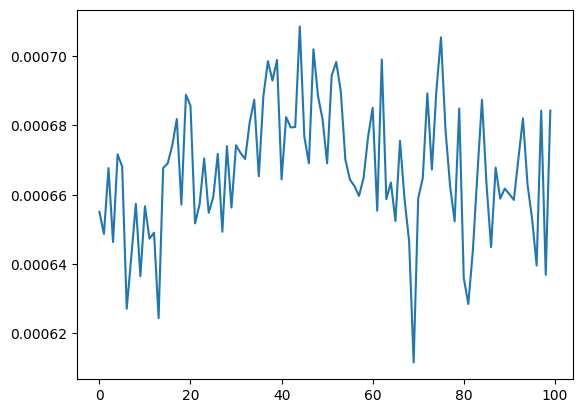

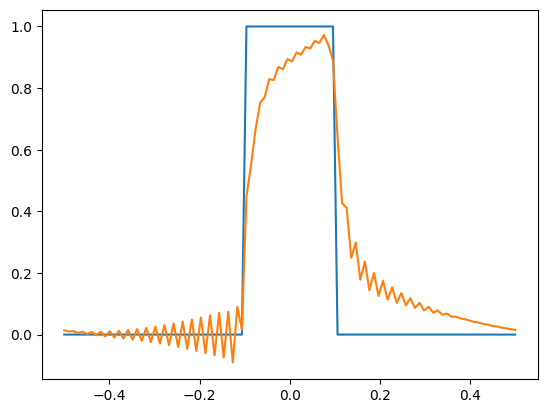

In [5]:
import torch.optim as optim
import matplotlib.pyplot as plt
import os

def train_mlp_filter(model, u_initial, dx, dt, N_t, learning_rate=1e-3, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)
    mse_loss = nn.MSELoss()
    
    u_list = []
    loss_list = []
        
    if os.path.exists("burgers_mlp_filter.pth"):
        model.load_state_dict(torch.load("burgers_mlp_filter.pth"))
        print("Model loaded from burgers_mlp_filter.pth")
    else:
        print("Model file does not exist. Training a new model.")
    
    model.train()
    for _epoch in range(epochs):
        optimizer.zero_grad()

        u = u_initial.copy()
        u_list.append(u.copy())
        loss = 0
        for t in range(N_t):

            u_exact = d_alembert_solution(u, x, dt, c)
            u_exact_tensor = torch.tensor(u_exact, dtype=torch.float32)

            u_rk4 = RK4(u, dx, dt)
            features = prepare_input_features(u_rk4)
            u_rk4_tensor = torch.tensor(u_rk4, dtype=torch.float32)
                    
            # Compute flux filtering
            up1, up2, up3, up4 = np.roll(u_rk4, -1), np.roll(u_rk4, -2), np.roll(u_rk4, -3), np.roll(u_rk4, -4)
            f2 = (up1 - u_rk4) / 4
            f8 = (35*(up1-u_rk4)-21*(up2-np.roll(u_rk4,1))+7*(up3-np.roll(u_rk4,2))-(up4-np.roll(u_rk4,3)))/(4**4)
            f2_tensor = torch.tensor(f2, dtype=torch.float32)
            f8_tensor = torch.tensor(f8, dtype=torch.float32)            
            
            w = model(features)
            w = w.squeeze(-1)
            filtered_u = u_rk4_tensor + w * (f2_tensor - f8_tensor)

            loss += mse_loss(filtered_u, u_exact_tensor)
            u = filtered_u.detach().numpy()
            u_list.append(u.copy())

        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        print(f"\repoch: {_epoch+1:3} loss: {loss.item():.5f}", end="")
        if (_epoch+1) % 10 == 0:
            torch.save(model.state_dict(), "burgers_mlp_filter.pth")
            print(f"\nModel saved to burgers_mlp_filter.pth")

    return np.array(u_list), np.array(loss_list)

u_list, loss_list = train_mlp_filter(model, u_initial, dx, dt, N_t, learning_rate=1e-3, epochs=200)

plt.plot(loss_list)
plt.yscale("log")
plt.show()

u_list_0 = u_list[:N_t+1]
u_list_trained = u_list[-N_t-1:]

plt.plot(x, u_list_trained[0])
plt.plot(x, u_list_trained[-1])
plt.show()
